In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch import optim
from sklearn.model_selection import train_test_split;

In [3]:
from argparse import Namespace

modelArgs = Namespace(
    
data_csv = 'timeSeriesData.csv',
model_state_file = "model.pth",
seed = 1300,
learning_rate = 0.001,
# dropout_p = 0.1,
batch_size = 40,
num_epochs = 80,
device = "cuda" if torch.cuda.is_available() else "cpu",

);

Data preparation 

In [4]:
def rnn_data_preparation(dataframe,window_size):
    df = dataframe.copy(deep = True);
    # df = df.set_index('date');
    for i in range(1 , window_size+1):
        df[f'meantemp(t-{i})'] = df['meantemp'].shift(i);
    df = df.dropna();
    return df;


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


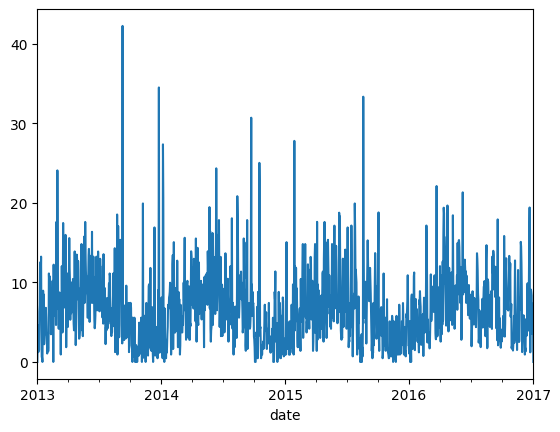

In [5]:
df = pd.read_csv("data/DailyDelhiClimateTrain.csv", parse_dates=['date'] , index_col = "date");
df.tail();
df['wind_speed'].plot()
df
# using mean rolling 
# plt.plot(df.index , df['meantemp'].rolling(window=6).mean())


##### Creating the data loader #####

In [6]:
prepared_data = rnn_data_preparation(df[['meantemp']],6);
prepared_data = prepared_data[prepared_data.columns[::-1]];
prepared_data

,meantemp(t-6),meantemp(t-5),meantemp(t-4),meantemp(t-3),meantemp(t-2),meantemp(t-1),meantemp
date,,,,,,,
2013-01-07,10.000000,7.400000,7.166667,8.666667,6.000000,7.000000,7.000000
2013-01-08,7.400000,7.166667,8.666667,6.000000,7.000000,7.000000,8.857143
2013-01-09,7.166667,8.666667,6.000000,7.000000,7.000000,8.857143,14.000000
2013-01-10,8.666667,6.000000,7.000000,7.000000,8.857143,14.000000,11.000000
2013-01-11,6.000000,7.000000,7.000000,8.857143,14.000000,11.000000,15.714286
...,...,...,...,...,...,...,...
2016-12-28,17.285714,15.550000,17.318182,14.000000,17.142857,16.850000,17.217391
2016-12-29,15.550000,17.318182,14.000000,17.142857,16.850000,17.217391,15.238095
2016-12-30,17.318182,14.000000,17.142857,16.850000,17.217391,15.238095,14.095238


Creating Data set

In [36]:
from torch.utils.data import Dataset, DataLoader

class DataSet(Dataset):
    def __init__(self , dataFrame:pd.DataFrame , x_columns:list , y_column:list) -> None:
        super().__init__();
        self.x_data = dataFrame[x_columns].to_numpy().reshape(-1,6,1);
        self.y_data = dataFrame[y_column].to_numpy().reshape(-1,1);
    
    
    def __getitem__(self, index):
        # self.x_data = self.x_data[index];
        # self.y_data = self.y_data[index];
        x_data_ = torch.tensor(self.x_data[index]);
        y_data_ = torch.tensor(self.y_data[index]);
        return x_data_ , y_data_;

    def __len__(self):
        return len(self.x_data);


# X_train, X_test, y_train, y_test = train_test_split(prepared_data[prepared_data.columns.drop(['meantemp'])],prepared_data['meantemp'] , test_size=0.2 , random_state=42);

limit = int(0.8*len(prepared_data));

train = prepared_data.iloc[:limit];

test = prepared_data.iloc[limit:];

train_data_set = DataSet(train,prepared_data.columns.drop(['meantemp']),'meantemp');

test_data_set = DataSet(test,prepared_data.columns.drop(['meantemp']),'meantemp');


Creating DataLoader

In [37]:
dataLoader = DataLoader(train_data_set , batch_size= modelArgs.batch_size);

In [38]:
# class Rnn(nn.Module):

#     def __init__(self,input_size , hidden_size , output_size , batch_size = modelArgs.batch_size):

#         super(Rnn,self).__init__();
#         self.hidden_size = hidden_size;
#         self.input_size = input_size;
#         self.output_size = output_size;
#         self.batch_size = batch_size
#         self.i2h = nn.Linear(self.input_size , self.hidden_size);
#         self.h2h = nn.Linear(self.hidden_size , self.hidden_size);
#         self.h2o = nn.Linear(self.hidden_size , self.output_size);
#         # self.sigmoid = nn.Sigmoid();
    
#     def forward(self,input_tensor,hidden_tensor):
#         input_hidden = self.i2h(input_tensor);        
#         hidden_hidden = self.h2h(hidden_tensor);
#         combined = (input_hidden + hidden_hidden);        
#         output = self.h2o(combined);

#         return output,combined;


#     def init_hidden(self, batch_size = modelArgs.batch_size):
#         return torch.zeros(batch_size,self.hidden_size , requires_grad=False);



# def train(model: Rnn, data: DataLoader, epochs: int, optimizer: optim.Optimizer, loss_fn: nn.Module , validationLoader : DataLoader):

#     train_losses = {};
#     validation_losses = {};

#     for epoch in range(epochs):
#             model.train();
#             epoch_losses = list();
#             epoch_val_losses = list();

#             for X, Y in data:
#                 # skip batch if it doesnt match with the batch_size
#                 # print(X.shape[0]);
#                 if X.shape[0] != modelArgs.batch_size:
#                     continue

#                 hidden = model.init_hidden(batch_size=modelArgs.batch_size)

#                 # send tensors to device
#                 X, Y, hidden = X.to(modelArgs.device), Y.to(modelArgs.device), hidden.to(modelArgs.device)

#                 # 2. clear gradients
#                 model.zero_grad()

#                 loss = 0
#                 # print(f'the shape is : {X.shape[1]}');

#                 for c in range(X.shape[1]):

#                     out, hidden = model(X.float()[:, c].reshape(X.shape[0],1), hidden);
                    

#                 loss = loss_fn(out, Y.float())

#                 # 4. Compte gradients gradients
#                 loss.backward()

#                 # 5. Adjust learnable parameters
#                 # clip as well to avoid vanishing and exploding gradients
#                 nn.utils.clip_grad_norm_(model.parameters(), 3)
#                 optimizer.step()
            
#                 epoch_losses.append(loss.detach().item() / X.shape[1])
 
#             train_losses[epoch] = torch.tensor(epoch_losses).mean();

#             model.eval();
#             for X, Y in validationLoader:
                
#                 loss_val = 0
                

#                 if X.shape[0] != modelArgs.batch_size:
#                     continue;
                
#                 hidden = model.init_hidden(batch_size=modelArgs.batch_size)
#                 X, Y, hidden = X.to(modelArgs.device), Y.to(modelArgs.device), hidden.to(modelArgs.device)


#                 for c in range(X.shape[1]):
#                     out, hidden = model(X.float()[:, c].reshape(X.shape[0],1), hidden);
                
#                 loss_val = loss_fn(out, Y.float());
              
#                 epoch_val_losses.append(loss_val / X.shape[1]);
            
#             validation_losses[epoch] = torch.tensor(epoch_val_losses).mean();


#     return model , train_losses , validation_losses;


# rnn = Rnn(1 , 128 , 1);
# loss = nn.MSELoss();
# optimizer = optim.RMSprop(rnn.parameters(), lr = 0.001);
# model, train_losses,validation_losses = train(rnn,dataLoader,modelArgs.num_epochs,optimizer=optimizer,loss_fn=loss, validationLoader = DataLoader(test_data_set));


In [53]:
def train_epoch(model, Dataloader, device , loss_function , optimizer):

    model.train();
    
    running_loss = 0;

    for batch_index, batch in enumerate(Dataloader):

        x_batch, y_batch = batch[0].to(device), batch[1].to(device);
        
        # print(x_batch.size() ,y_batch.size());

        output = model(x_batch.float());
        
        # print(output);
        
        loss = loss_function(output, y_batch.float());
        
        running_loss += loss;
        
        optimizer.zero_grad();
        
        loss.backward();
        
        optimizer.step();
        
        if(batch_index % 100 == 99):
        
            avg_loss = running_loss / 100;
        
            print(f'-------------batch {batch_index}, Loss {avg_loss}-----------------');
        
            running_loss = 0.0;
    return model;


In [58]:
def validate_epoch(model, Dataloader, device,loss_function):
    
    model.eval();    
    running_loss = 0;
    
    for batch_index, batch in enumerate(Dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device);
        
        with torch.no_grad():

            output = model(x_batch.float());
            
            loss = loss_function(output, y_batch.float());
            
            running_loss += loss;
                    
            
    avg_loss = running_loss / len(dataLoader);
    
    print(f'-----------Val loss {avg_loss}-------------');
        

In [59]:
# LSTM Class implementation 
class LSTM(nn.Module):
    def __init__(self,hidden_size,input_size,num_stacked_layers):
        super().__init__();
        self.hidden_size = hidden_size;
        self.input_size = input_size;
        self.num_stacked_layers = num_stacked_layers;
        self.lstm = nn.LSTM(self.input_size , self.hidden_size , self.num_stacked_layers , batch_first=True);
        self.fc = nn.Linear(self.hidden_size,1);
    
    def forward(self,input):
        # print(input.size(0))
        self.h0 = torch.zeros(self.num_stacked_layers , input.size(0), self.hidden_size ).to(modelArgs.device);
        self.c0 = torch.zeros(self.num_stacked_layers , input.size(0), self.hidden_size ).to(modelArgs.device);
        out,_ = self.lstm(input,(self.h0 , self.c0));
        out = self.fc(out[:,-1,:]);
        return out;


model = LSTM(4,1,1);
model.to(modelArgs.device);
loss_function = nn.MSELoss();
optimizer = torch.optim.Adam(model.parameters() , lr = modelArgs.learning_rate);

for epoch in range(modelArgs.num_epochs):
    model = train_epoch(model,dataLoader,modelArgs.device,loss_function,optimizer);
    validate_epoch(model,DataLoader(test_data_set),modelArgs.device,loss_function);


torch.Size([40, 6, 1]) torch.Size([40, 1])
40
tensor([[-0.4080],
        [-0.4099],
        [-0.3977],
        [-0.3517],
        [-0.3255],
        [-0.3011],
        [-0.2750],
        [-0.2588],
        [-0.2427],
        [-0.2482],
        [-0.2407],
        [-0.2439],
        [-0.2357],
        [-0.2411],
        [-0.2495],
        [-0.2687],
        [-0.2909],
        [-0.3002],
        [-0.2856],
        [-0.2785],
        [-0.2775],
        [-0.2743],
        [-0.2645],
        [-0.2577],
        [-0.2542],
        [-0.2463],
        [-0.2365],
        [-0.2296],
        [-0.2263],
        [-0.2181],
        [-0.2124],
        [-0.2117],
        [-0.2096],
        [-0.2101],
        [-0.2220],
        [-0.2263],
        [-0.2295],
        [-0.2295],
        [-0.2299],
        [-0.2252]], grad_fn=<AddmmBackward0>)
torch.Size([40, 6, 1]) torch.Size([40, 1])
40
tensor([[-0.2119],
        [-0.1986],
        [-0.2011],
        [-0.2097],
        [-0.2123],
        [-0.2162],
       

KeyboardInterrupt: 

In [ ]:
train_epoch()

{0: tensor(1.1654), 1: tensor(0.7200), 2: tensor(0.6464), 3: tensor(0.6966), 4: tensor(1.0764), 5: tensor(0.5850), 6: tensor(0.5770), 7: tensor(0.5653), 8: tensor(0.6397), 9: tensor(0.5483), 10: tensor(0.5535), 11: tensor(0.5444), 12: tensor(0.5354), 13: tensor(1.1366), 14: tensor(0.6952), 15: tensor(0.5346), 16: tensor(0.5521), 17: tensor(0.5568), 18: tensor(0.5522), 19: tensor(0.6062), 20: tensor(0.5651), 21: tensor(0.7981), 22: tensor(0.5421), 23: tensor(0.5143), 24: tensor(0.5330), 25: tensor(0.5983), 26: tensor(0.5385), 27: tensor(0.6172), 28: tensor(0.5146), 29: tensor(0.5716), 30: tensor(0.4933), 31: tensor(0.5224), 32: tensor(0.8532), 33: tensor(0.4912), 34: tensor(0.6594), 35: tensor(0.6055), 36: tensor(0.6736), 37: tensor(0.4924), 38: tensor(0.5084), 39: tensor(0.6494), 40: tensor(0.5110), 41: tensor(0.5050), 42: tensor(0.4921), 43: tensor(0.4926), 44: tensor(0.5037), 45: tensor(0.5195), 46: tensor(0.5844), 47: tensor(0.5024), 48: tensor(0.4867), 49: tensor(0.4970), 50: tenso

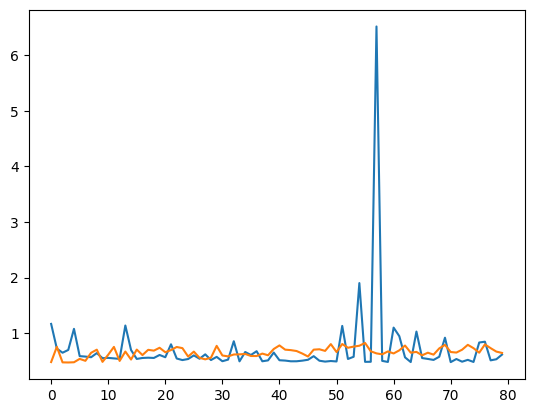

In [ ]:
# print(train_losses)
# # plt.plot(train_losses.keys() , train_losses.values());
# plt.plot(validation_losses.keys() , validation_losses.values());

In [ ]:
# # classifier(x = torch.stack((torch.tensor(vectorizer.vectorize("this is a bad movie ",267)).to(modelArgs.device),torch.tensor(vectorizer.vectorize("The movie is not good enough",267)).to(modelArgs.device))))

# # torch.save(model.state_dict(), 'model.pth')


# total_loss = 0;

# model.eval();
# # print(dataset.test_size)
    

# for X,Y in DataLoader(test_data_set): 

#     hidden = model.init_hidden();

#     X, Y , hidden = X.to(modelArgs.device), Y.to(modelArgs.device),hidden.to(modelArgs.device);

#     for c in range(X.shape[1]):

#             # print(f'X size is {X.float()[:, c].reshape(X.shape[0],1).size()}');

#             # print(f'Hidden size is {hidden.size()}');

#             out, hidden = model(X.float()[:, c].reshape(X.shape[0],1), hidden);
#             # print(out);
#             print(Y);



#     # y_pred = model(X.float() , hidden.float());
#     print(f'Prediction is {out}');
#     total_loss += (out - Y)**2;
#     print(f'True value is : {Y}');

    
# total_loss = total_loss / test_data_set.__len__();
# print(f'total loss : {total_loss}');

/tmp/ipykernel_34721/3696815292.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_data = torch.tensor(self.x_data.iloc[index]);


tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
tensor([23.9375], dtype=torch.float64)
Prediction is tensor([[23.9815]], grad_fn=<AddmmBackward0>)
True value is : tensor([23.9375], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
tensor([26.3125], dtype=torch.float64)
Prediction is tensor([[23.8996]], grad_fn=<AddmmBackward0>)
True value is : tensor([26.3125], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
tensor([26.1875], dtype=torch.float64)
Prediction is tensor([[25.7833]], grad_fn=<AddmmBackward0>)
True val